Reference: https://www.kaggle.com/code/eriknovak/pytorch-roberta-named-entity-recognition

In [2]:
# visualization libraries
import matplotlib.pyplot as plt
import numpy as np

# pytorch libraries
import torch # the main pytorch library
import torch.nn as nn # the sub-library containing Softmax, Module and other useful functions
import torch.optim as optim # the sub-library containing the common optimizers (SGD, Adam, etc.)

# huggingface's transformers library
from transformers import RobertaForTokenClassification, RobertaTokenizer

# huggingface's datasets library
from datasets import load_dataset

# the tqdm library used to show the iteration progress
import tqdm
tqdmn = tqdm.notebook.tqdm

In [3]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [4]:
dataset = load_dataset("conll2003")

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [6]:
dataset['train'][0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

In [7]:
def add_encodings(example):
    """Processing the example

    Args:
        example (dict): The dataset example.

    Returns:
        dict: The dictionary containing the following updates:
            - input_ids: The list of input ids of the tokens.
            - attention_mask: The attention mask list.
            - ner_tags: The updated ner_tags.

    """
    # get the encodings of the tokens. The tokens are already split, that is why we must add is_split_into_words=True
    encodings = tokenizer(example['tokens'], truncation=True, padding='max_length', is_split_into_words=True)
    # extend the ner_tags so that it matches the max_length of the input_ids
    labels = example['ner_tags'] + [0] * (tokenizer.model_max_length - len(example['ner_tags']))
    # return the encodings and the extended ner_tags
    return { **encodings, 'labels': labels }

In [8]:
# modify/format all datasets so that they include the 'input_ids', 'attention_mask'
# and 'labels' used to train and evaluate the model
dataset = dataset.map(add_encodings)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [9]:
# format the datasets so that we return only 'input_ids', 'attention_mask' and 'labels'
# making it easier to train and validate the model
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [10]:
# get the NER labels and create two dictionaries for accessing their ids
labels = dataset['train'].features['ner_tags'].feature
label2id = { k: labels.str2int(k) for k in labels.names }
id2label = { v: k for k, v in label2id.items() }

In [11]:
# initialize the model and provide the 'num_labels' used to create the classification layer
model = RobertaForTokenClassification.from_pretrained('roberta-base', id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# set the model in 'train' mode and send it to the device
model.train().to(device)
# initialize the Adam optimizer (used for training/updating the model)
optimizer = optim.AdamW(params=model.parameters(), lr=1e-5)

In [18]:
# set the number of epochs
n_epochs = 3
# batch the train data so that each batch contains 4 examples (using 'batch_size')
train_data = torch.utils.data.DataLoader(dataset['train'], batch_size=4)

In [22]:
train_loss = []
# iterate through the data 'n_epochs' times
for epoch in tqdmn(range(n_epochs)):
    current_loss = 0
    # iterate through each batch of the train data
    for i, batch in enumerate(tqdmn(train_data)):
        # move the batch tensors to the same device as the
        batch = { k: v.to(device) for k, v in batch.items() }
        # send 'input_ids', 'attention_mask' and 'labels' to the model
        outputs = model(**batch)
        # the outputs are of shape (loss, logits)
        loss = outputs[0]
        # with the .backward method it calculates all
        # of  the gradients used for autograd
        loss.backward()
        # NOTE: if we append `loss` (a tensor) we will force the GPU to save
        # the loss into its memory, potentially filling it up. To avoid this
        # we rather store its float value, which can be accessed through the
        # `.item` method
        current_loss += loss.item()
        if i % 8 == 0 and i > 0:
            # update the model using the optimizer
            optimizer.step()
            # once we update the model we set the gradients to zero
            optimizer.zero_grad()
            # store the loss value for visualization
            train_loss.append(current_loss / 32)
            current_loss = 0
    # update the model one last time for this epoch
    optimizer.step()
    optimizer.zero_grad()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3511 [00:00<?, ?it/s]

  0%|          | 0/3511 [00:00<?, ?it/s]

  0%|          | 0/3511 [00:00<?, ?it/s]

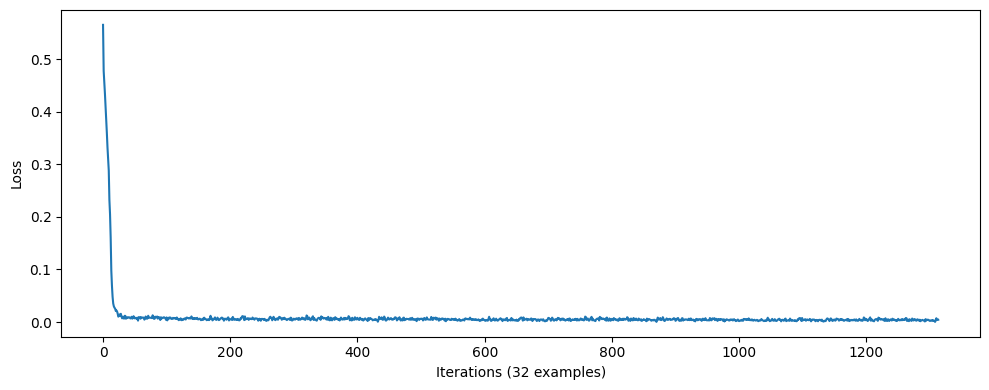

In [23]:
fig, ax = plt.subplots(figsize=(10, 4))
# visualize the loss values
ax.plot(train_loss)
# set the labels
ax.set_ylabel('Loss')
ax.set_xlabel('Iterations (32 examples)')
fig.tight_layout()
plt.show()

In [24]:
model = model.eval()
# batch the train data so that each batch contains 4 examples (using 'batch_size')
test_data = torch.utils.data.DataLoader(dataset['test'], batch_size=4)

In [26]:
num_labels = dataset['train'].features['ner_tags'].feature.num_classes

# create the confusion matrix
confusion = torch.zeros(num_labels, num_labels)

# iterate through each batch of the train data
for i, batch in enumerate(tqdmn(test_data)):
    # do not calculate the gradients
    with torch.no_grad():
        # move the batch tensors to the same device as the model
        batch = { k: v.to(device) for k, v in batch.items() }
        # send 'input_ids', 'attention_mask' and 'labels' to the model
        outputs = model(**batch)

    # get the sentence lengths
    s_lengths = batch['attention_mask'].sum(dim=1)
    # iterate through the examples
    for idx, length in enumerate(s_lengths):
        # get the true values
        true_values = batch['labels'][idx][:length]
        # get the predicted values
        pred_values = torch.argmax(outputs[1], dim=2)[idx][:length]
        # go through all true and predicted values and store them in the confusion matrix
        for true, pred in zip(true_values, pred_values):
            confusion[true.item()][pred.item()] += 1

  0%|          | 0/864 [00:00<?, ?it/s]

In [27]:
# Normalize by dividing every row by its sum
for i in range(num_labels):
    confusion[i] = confusion[i] / confusion[i].sum()

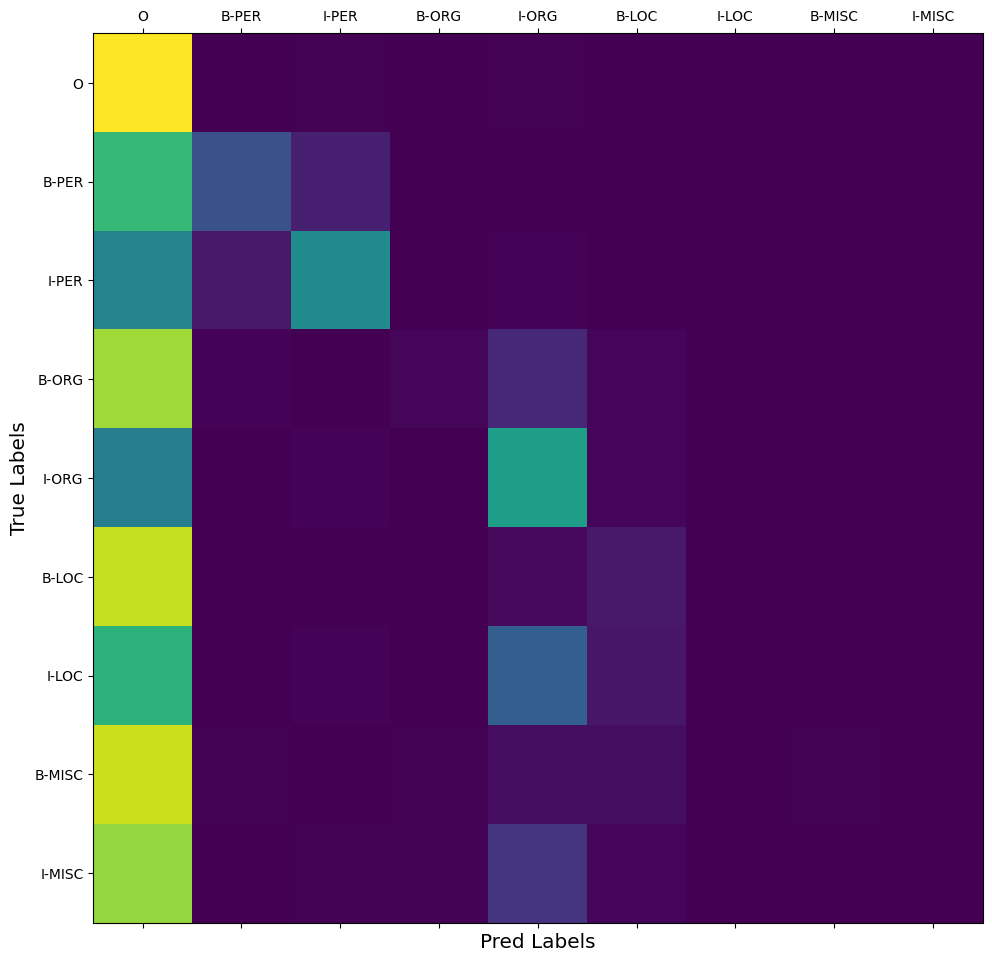

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
# visualize the loss values
ax.matshow(confusion.numpy())

# get the labels
labels = list(label2id.keys())
ids = np.arange(len(labels))

ax.set_ylabel('True Labels', fontsize='x-large')
ax.set_xlabel('Pred Labels', fontsize='x-large')

# set the x ticks
ax.set_xticks(ids)
ax.set_xticklabels(labels)

# set the y ticks
ax.set_yticks(ids)
ax.set_yticklabels(labels)

# plot figure
fig.tight_layout()
plt.show()